In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.Luminosity.photosphere import get_photosphere
from src.Optical_Depth.opacity_table import opacity

In [2]:
c = 2.9979e10 #[cm/s]
h = 6.6261e-27 #[gcm^2/s]
Kb = 1.3806e-16 #[gcm^2/s^2K]
alpha = 7.5646 * 10**(-15) # radiation density [erg/cm^3K^4]
Rsol_to_cm = 6.957e10
const_npeak = 5.879e10 #[Hz/K]

In [3]:
n_min = 1e12 
n_max = 1e18 
n_spacing = 1000
n_array = np.logspace(np.log10(n_min),np.log10(n_max), num = n_spacing)
m = 6
fix = 844

In [4]:
def emissivity(Temperature, Density, cell_vol):
    """Arguments in CGS. Gives emissivity in a cell. """
    k_planck = opacity(Temperature, Density, 'planck', ln = False)
    emiss = alpha * c * Temperature**4 * k_planck * cell_vol
    return emiss

def find_peak(Temperature):
    """Find n peak with Wien law."""
    npeak = const_npeak * Temperature
    return 10*npeak

def planck_fun_n_cell(Temperature: float, n: float) -> float:
    """ Planck function in a cell. """
    const = 2*h/c**2
    peak = find_peak(Temperature)
    if n> 10*peak:
        fun = 0
        print('too high frequency: no energy here for this cell')
    else:
        fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)
    return fun

too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: no energy here for this cell
too high frequency: 

[]

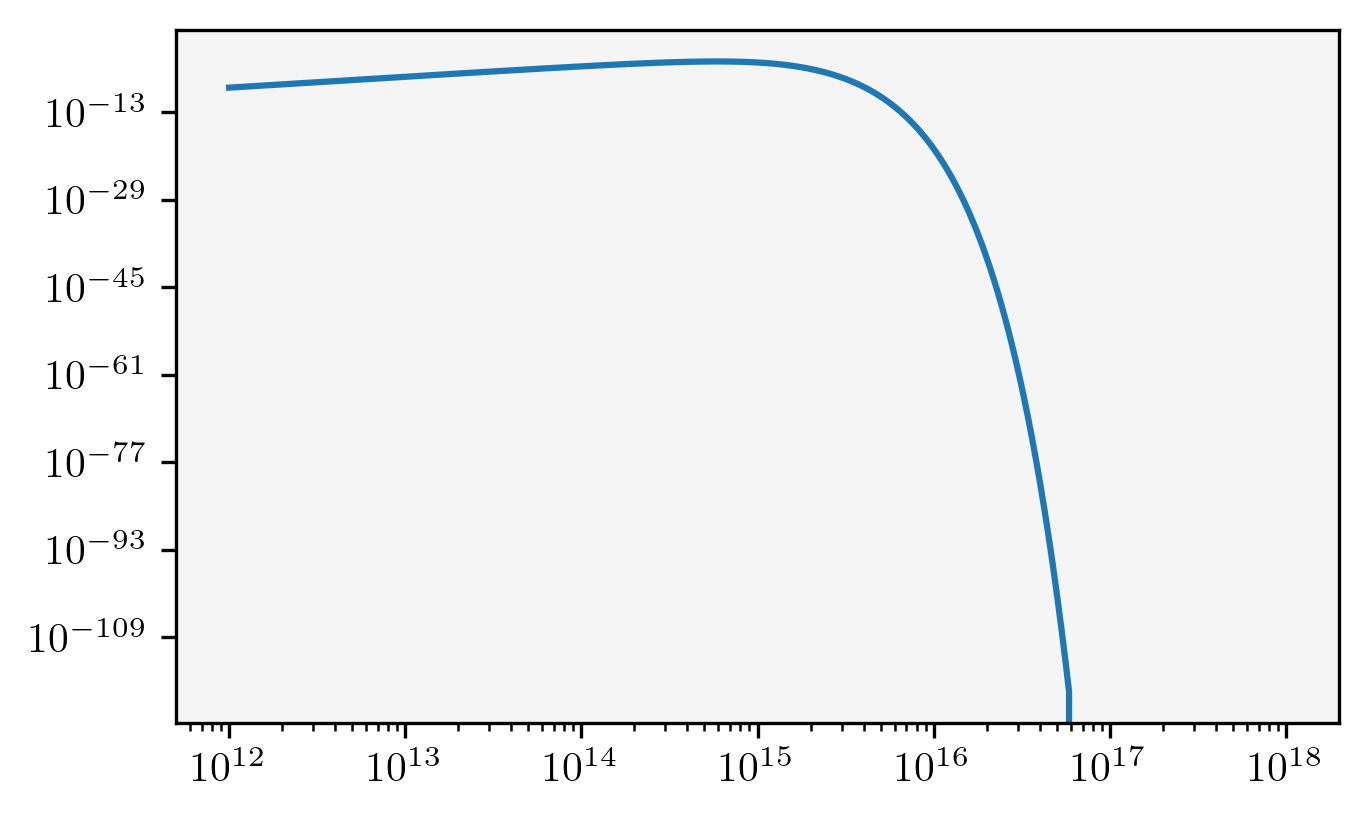

In [5]:
#CHECK PLANCK
check_planck_n = []
for n in n_array:
    a = planck_fun_n_cell(1e4, n)
    check_planck_n.append(a)
plt.plot(n_array,check_planck_n)
plt.loglog()

In [6]:
def planck_fun_cell(Temperature: float) -> float:
    """
    Bolometric planck function in a cell. 
    We select the range for frequency in order to no overcome the peak or we have a mess.
    """
    planck_fun_n_array = []
    peak = find_peak(Temperature)
    n_arr = np.linspace(n_min,peak,n_spacing)
    print('peak:', peak)
    for n in n_arr:
        planck_fun_n_array_single = planck_fun_n_cell(Temperature, n)
        planck_fun_n_array.append(planck_fun_n_array_single)
    planck_fun_n_array = np.array(planck_fun_n_array)
    fun = np.trapz(planck_fun_n_array, n_arr)
    return fun


In [7]:
#CHECK PLANCK BOLO: ok in agreement with Wolphram (https://www.wolframalpha.com/input?i=int%282*6.6261*10%5E%28-27%29x%5E3%2F%28%282.99*10%5E10%29**2*%28exp%286.6261*10%5E%28-11%29x%2F%281.3806*10%5E7%29%29-1%29%29%29++from+x+%3D10%5E12+to+x+%3D5.879*10%5E18)
a = planck_fun_cell(1e7)
print(a)

peak: 5.879e+18
1.8046852155423343e+23


In [8]:
def luminosity_n(Temperature: float, Density: float, tau: float, volume: float, n:int):
    """
    Temperature, Density and volume: np.array from near to the BH to far away. Thus we will use negative index in the for loop.
    tau: np.array from outside to inside.
    n is the frequency.

    We obtain luminosity (at a chosen frequency n) in a cell.
    """
    epsilon = emissivity(Temperature, Density, volume)
    lum_cell = epsilon * planck_fun_n_cell(Temperature, n) * np.exp(-tau)
    return (lum_cell/planck_fun_cell(Temperature))

def luminosity(Temperature: float, Density: float, tau: float, volume: float) -> int:
    """Gives NOT normalised bolometric luminosity in a cell."""
    lum_n_array = []
    peak = find_peak(Temperature)
    n_arr = np.linspace(n_min,peak,n_spacing)
    for n in n_arr:
        value = luminosity_n(Temperature, Density, tau, volume, n)
        lum_n_array.append(value)
    lum_n_array = np.array(lum_n_array)
    lum = np.trapz(lum_n_array, n_arr)
    return lum
    
def normalisation(Temperature: float, Density: float, tau: float, volume: float, luminosity_fld: float) -> float:
    """ Find the normalisation constant from FLD model. """      
    norm = luminosity_fld / luminosity(Temperature, Density, tau, volume)
    print('L: ',luminosity(Temperature, Density, tau, volume))
    print('norm: ',norm)
    return  norm